# SpMAX4_Bh(s) Categorization Analysis of 60 Experimentally Tested Molecules for Indocyanine Nanoparticle Formation
SpMAX4_Bh(s) values of drugs were calculated by Dragon 6 software.

In [1]:
import pandas as pd
import numpy as np
import os
import re
from __future__ import print_function, division
import matplotlib.pyplot as plt
%matplotlib inline

#### Import experimental data and descriptor values

In [2]:
df_molecules = pd.read_csv("experimental_dataset_N60_SpMAX4Bhs.csv")
df_molecules.head()

,Drug Name,SpMAX4_Bh(s),Experimental INP Formation,SpMAX4_Bh(s) Analysis Group
0,ABT737,7.00,Yes,Validation
1,Apitolisib,5.01,No,Validation
2,Avagacestat,8.00,Yes,Validation
3,Avasimibe,4.79,Yes,Validation
4,AZD-4547,4.72,No,Validation


### 1. SpMAX4_Bh(s) vs SpMAX4_Bh(s) Rank

/Users/isikm/opt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


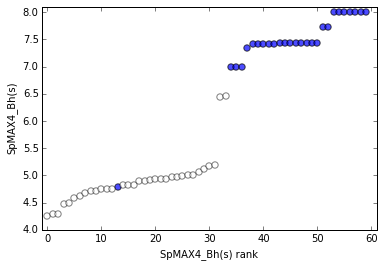

In [3]:
df_exp_sorted = df_molecules.sort_values(by="SpMAX4_Bh(s)", ascending=1).reset_index(drop=True)
df_exp_sorted["SpMAX4_Bh(s) rank"]=df_exp_sorted.index

df_exp_yes_sorted = df_exp_sorted.loc[df_exp_sorted["Experimental INP Formation"] == "Yes"].reset_index(drop=True)
df_exp_no_sorted = df_exp_sorted.loc[df_exp_sorted["Experimental INP Formation"] == "No"].reset_index(drop=True)

SpMAX4_array_yes_sorted = df_exp_yes_sorted.ix[:,"SpMAX4_Bh(s)"]
SpMAX4_rank_array_yes_sorted = df_exp_yes_sorted.ix[:,"SpMAX4_Bh(s) rank"]
SpMAX4_array_no_sorted = df_exp_no_sorted.ix[:,"SpMAX4_Bh(s)"]
SpMAX4_rank_array_no_sorted = df_exp_no_sorted.ix[:,"SpMAX4_Bh(s) rank"]

fig = plt.figure(1, figsize=(6,4), dpi=200)

plt.scatter(SpMAX4_rank_array_yes_sorted, SpMAX4_array_yes_sorted, alpha=0.7, c="b", s=40 )
plt.scatter(SpMAX4_rank_array_no_sorted, SpMAX4_array_no_sorted, alpha=0.5,  c="w", s=40)
plt.xlabel("SpMAX4_Bh(s) rank")
plt.ylabel("SpMAX4_Bh(s)")
plt.xlim(-1,61)
plt.ylim(4,8.1)
plt.savefig("SpMAX4_rank.png", dpi=200)
plt.savefig("SpMAX4_rank.svg")

### 2. SpMAX4_Bh(s) Box Plot

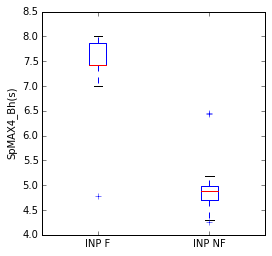

In [4]:
SpMAX4_array_yes = df_exp_yes_sorted.ix[:,"SpMAX4_Bh(s)"].astype(float)
SpMAX4_array_no = df_exp_no_sorted.ix[:,"SpMAX4_Bh(s)"].astype(float)

data=[SpMAX4_array_yes, SpMAX4_array_no]

fig=plt.figure(1, figsize=(4,4))
ax= fig.add_subplot(111)

ax.boxplot(data)
ax.set_xticklabels(["INP F","INP NF"])
ax.set_ylabel("SpMAX4_Bh(s)")
ax.set_ylim(4, 8.5)
fig.savefig("SpMAX4_boxplot.png", dpi=200)
plt.savefig("SpMAX4_boxplot.svg")

In [5]:
from scipy import stats
print(stats.ttest_ind(SpMAX4_array_yes, SpMAX4_array_no, equal_var=False))
import numpy as np, statsmodels.stats.api as sms
cm = sms.CompareMeans(sms.DescrStatsW(SpMAX4_array_yes), sms.DescrStatsW(SpMAX4_array_no))
print("95% CI: ", cm.tconfint_diff(usevar='unequal'))

Ttest_indResult(statistic=17.660602029024361, pvalue=1.7150623429456308e-22)
95% CI:  (2.2567322817879978, 2.8368030717473554)


### 3. SpMAX4_Bh(s) Logistic Regression

In [6]:
from scipy import optimize

def logistic(params,x):
    """ 
    Logistic function

    Parameters
    ----------
    params : list or numpy array
      the three parameters of the logistic function
      First parameter is set to 1 to make the function
      span 0 to 1.
    x : numpy array
      the explanatory variable
   
    Return
    ------
    numpy array
      the output of the logistic function

    """
    params[0]=1
    return params[0]/(1+np.exp(-x*params[1] - params[2])) 

def residuals(params):
    predicted = logistic(params,x)
    return np.sum((y-predicted)**2)

In [7]:
df_molecules["Experimental Category"]=None

for i,row in enumerate(df_molecules.iterrows()):
    if df_molecules.ix[i,"Experimental INP Formation"] == "Yes" :
        df_molecules.ix[i, "Experimental Category"] = 1
    else:
        df_molecules.ix[i, "Experimental Category"] = 0

df_molecules.head()

,Drug Name,SpMAX4_Bh(s),Experimental INP Formation,SpMAX4_Bh(s) Analysis Group,Experimental Category
0,ABT737,7.00,Yes,Validation,1
1,Apitolisib,5.01,No,Validation,0
2,Avagacestat,8.00,Yes,Validation,1
3,Avasimibe,4.79,Yes,Validation,1
4,AZD-4547,4.72,No,Validation,0


The predicted parameters are  [   1.           92.28979267 -620.53400363]
Threshold SpMAX4_Bh(s):  6.72375552812


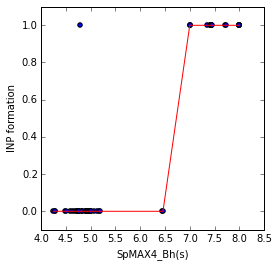

In [8]:
fig = plt.figure(1, figsize=(4,4))

df_sorted = df_molecules.sort_values(by="SpMAX4_Bh(s)", ascending=1).reset_index(drop=True)
initial_guess = [1,1,1]
x=df_sorted.ix[:, "SpMAX4_Bh(s)"].astype(float)
y=df_sorted.ix[:, "Experimental Category"]

fit = optimize.minimize(residuals,initial_guess,method='Nelder-Mead')
print("The predicted parameters are ", fit.x)

# Inflection point is -x_0/b
threshold_SpMAX4 =(-1)*fit.x[2]/fit.x[1]
print("Threshold SpMAX4_Bh(s): ", threshold_SpMAX4)
    
plt.scatter(x,y)
predicted = logistic(fit.x, x)
plt.plot(x,predicted,color="red")
plt.xlabel('SpMAX4_Bh(s)')
plt.ylabel('INP formation', size=10)
plt.ylim(-0.1, 1.1)
plt.savefig("SpMAX4_logistic_fit.png", dpi=200)
plt.savefig("SpMAX4_logistic_fit.svg")

### 4. SpMAX4_Bh(s) ROC Curve

In [9]:
from sklearn import metrics

y_actual = df_sorted["Experimental Category"]
# predicted score come from logistic regression
y_predicted = predicted

# ROC
fpr, tpr, thresholds = metrics.roc_curve(y_actual, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

print("AUC: {0:0.3f}".format(roc_auc))

AUC: 0.978


#### Bootstrap for ROC AUC confidence intervals

Original ROC area: 0.978
95% Confidence interval for the score: [0.923 - 1.0]


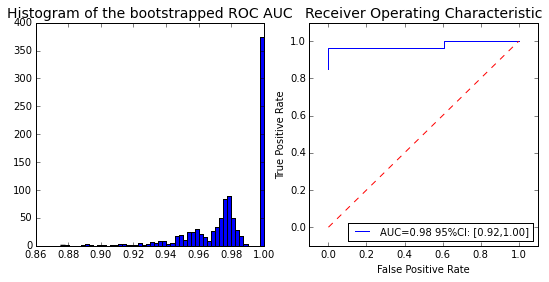

In [10]:
y_actual = np.array(y_actual).astype(int)
y_predicted = np.array(y_predicted)
print("Original ROC area: {:0.3f}".format(metrics.roc_auc_score(y_actual, y_predicted)))

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):

    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.random_integers(0, len(y_predicted) - 1, len(y_predicted))
 
    if len(np.unique(y_actual[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = metrics.roc_auc_score(y_actual[indices], y_predicted[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

fig = plt.figure(1, figsize=(9,4))
plt.subplot(1,2,1)
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC', size=14)
# plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 95% confidence interval
# 95% CI percentiles to 0.025 and 0.975
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("95% Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

# Plotting ROC curve
#fig = plt.figure(1, figsize=(4,4))
plt.subplot(1,2,2)
plt.title('Receiver Operating Characteristic', size=14)
plt.plot(fpr, tpr, 'b', label='AUC={0:0.2f} 95%CI: [{1:0.2f},{2:0.2f}]'.format(roc_auc, confidence_lower, confidence_upper))
plt.legend(loc='lower right', prop={'size':10})
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("SpMAX4_ROC_with_histogram.png", dpi=200)
plt.savefig("SpMAX4_ROC_with_histogram.svg")

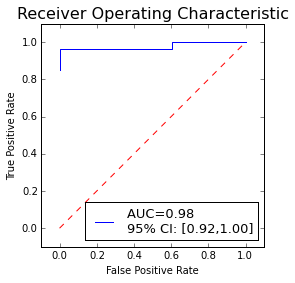

In [11]:
# Plotting ROC curve
fig = plt.figure(1, figsize=(4,4))
plt.title('Receiver Operating Characteristic', size=16)
plt.plot(fpr, tpr, 'b', label='AUC={0:0.2f} \n95% CI: [{1:0.2f},{2:0.2f}]'.format(roc_auc, confidence_lower, confidence_upper))
plt.legend(loc='lower right', prop={'size':13})
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("SpMAX4_ROC.png", dpi=200)
plt.savefig("SpMAX4_ROC.svg")

### 5. SpMAX4_Bh(s) Confusion Matrix
Threshold for confusion matrix was determined by inflection point of logistic regression.

In [12]:
df_molecules["Pred Category by SpMAX4_Bh(s)"]= None
    
for i, row in enumerate(df_molecules.iterrows()):
    logP = float(df_molecules.ix[i, "SpMAX4_Bh(s)"])
    #print(logD)
    if logP < threshold_SpMAX4:
        df_molecules.ix[i, "Pred Category by SpMAX4_Bh(s)"] = 0
    else:
        df_molecules.ix[i, "Pred Category by SpMAX4_Bh(s)"] = 1
df_molecules.head()

,Drug Name,SpMAX4_Bh(s),Experimental INP Formation,SpMAX4_Bh(s) Analysis Group,Experimental Category,Pred Category by SpMAX4_Bh(s)
0,ABT737,7.00,Yes,Validation,1,1
1,Apitolisib,5.01,No,Validation,0,0
2,Avagacestat,8.00,Yes,Validation,1,1
3,Avasimibe,4.79,Yes,Validation,1,0
4,AZD-4547,4.72,No,Validation,0,0


In [13]:
exp_NP = df_molecules.ix[:,"Experimental Category"].astype(int)
pred_NP = df_molecules.ix[:, "Pred Category by SpMAX4_Bh(s)"].astype(int)

actual = pd.Series(exp_NP, name= "Actual")
predicted = pd.Series(pred_NP, name= "Predicted")
df_confusion = pd.crosstab(actual, predicted)
    
# Accuracy = (TP+TN)/(TP+TN+FP+FN)
TP = df_confusion.ix[1,1]
TN = df_confusion.ix[0,0]
FP = df_confusion.ix[0,1]
FN = df_confusion.ix[1,0]
    
accuracy = (TP+TN)/(TP+TN+FP+FN)
    
print("SpMAX4_Bh(s) ", "\nAccuracy= {:.2f}".format(accuracy))
print("SpMAX4_Bh(s)  threshold= {:.2f}\n".format(threshold_SpMAX4))
print(df_confusion, "\n")

SpMAX4_Bh(s)  
Accuracy= 0.98
SpMAX4_Bh(s)  threshold= 6.72

Predicted   0   1
Actual           
0          33   0
1           1  26 

